## Бутстрап для анализа средних и медиан, сравнение с критерием Манна-Уитни


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [18]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    alternative = 'two-sided'         # or 'greater', 'less'  (двусторонняя\односторонняя гипотеза)
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    
    if alternative == 'two-sided':
        p_value = min(p_1, p_2) * 2
    elif alternative == 'less':
        p_value = min(p_1, p_2)
    elif alternative == 'greater':
        p_value = max(p_1, p_2)           
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('red')
            #bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### Задача

Сравнить средние и медианы в подвыборках с помощью бутрсрапа и критерия Манна-Уитни

In [27]:
path = 'https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv'

In [28]:
df = pd.read_csv(path, sep=';', decimal=',')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [30]:
df.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [31]:
# разделим выборку на две части
control = df[df.experimentVariant == 'Control']
test = df[df.experimentVariant == 'Treatment']

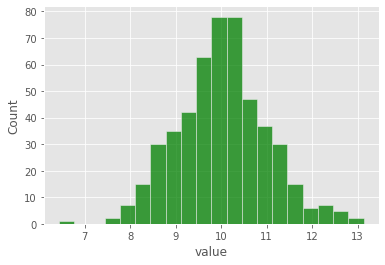

In [42]:
# посмотрим на распределения для каждой подгруппы
sns.histplot(control.value, kde=False, bins=20, color='green');

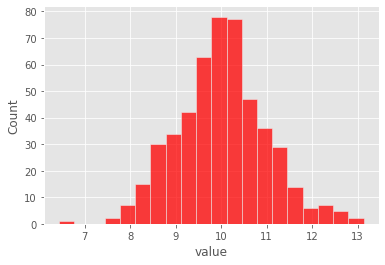

In [41]:
sns.histplot(test[test.value < 20].value, kde=False, bins=20, color='red');

In [97]:
# в тестовой подвыборке есть значительно отклоняющиеся значения, из-за которых средние и будут расходиться
test[test.value > 20].value

995    1000.0
996    1200.0
997    1500.0
998    2000.0
999    3000.0
Name: value, dtype: float64

In [44]:
# а в контрольной выборке все значения меньше 20
control[control.value > 20].value

Series([], Name: value, dtype: float64)

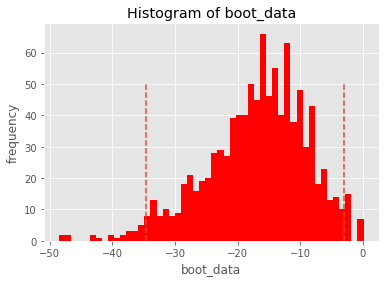

In [45]:
# проверим средние бутстрапом
exp1 = get_bootstrap(control.value, 
                     test.value, 
                     boot_it = 1000, 
                     statistic = np.mean, 
                     bootstrap_conf_level = 0.95,
                     alternative = 'two-sided')

In [46]:
exp1["p_value"] 

0.036787408182151565

In [47]:
exp1["quants"] 

,0
0.025,-34.652729
0.975,-2.961796


Доверительный интервал разницы средних не содержит ноль, значит средние стат. значимо различаются

In [102]:
mannwhitneyu(control.value, test.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

При этом критерий Манна-Уитни говорит об отсутсвии различий

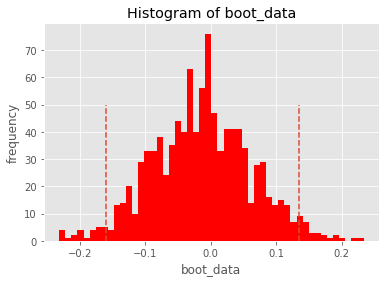

In [49]:
# во втором эксперименте проверим медианы
exp2 = get_bootstrap(control.value, 
                     test.value, 
                     boot_it = 1000, 
                     statistic = np.median, 
                     bootstrap_conf_level = 0.95,
                     alternative = 'two-sided')

In [116]:
exp2["p_value"] 

0.9297617098512443

In [117]:
exp2["quants"] 

,0
0.025,-0.157306
0.975,0.138597


Здесь уже ноль входит в интервал, следовательно различий нет

In [118]:
mannwhitneyu(control.value, test.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

Критерий Манна-Уитни также снова говорит об отсутсвии различий

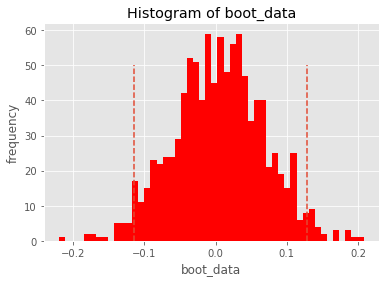

In [51]:
# в третьем эксперименте проверим средние, исключив в тестовой подвыборке выбросы
exp3 = get_bootstrap(control.value, 
                     test[test.value < 20].value, 
                     boot_it = 1000, 
                     statistic = np.mean, 
                     bootstrap_conf_level = 0.95,
                     alternative = 'two-sided')

In [120]:
exp3["p_value"] 

0.9358220442974359

In [121]:
exp3["quants"] 

,0
0.025,-0.120930
0.975,0.130401


Теперь и для средних различий нет

In [122]:
mannwhitneyu(control.value, test[test.value < 20].value)

MannwhitneyuResult(statistic=123310.5, pvalue=0.4614193132073732)

### Вывод:

При оценке разности средних бутстрапом ноль не входит в доверительный интервал (значение pvalue около 0.04). Так происходит из-за пяти больших выбросов в тестовой подвыборке. Тогда как оценка по медиане не дает значимых различий, потому что количество выбросов мало относительно размера подвыборки. Если исключить эти выбросы из тестовой подвыборки, то оценка для средних практически совпадает с оценкой для медиан. И тоже отклоняет альтернативную гипотезу.
    

Критерий Манна-Уитни во всех случаях не позволяет принять альтернативную гипотезу. Однако его значение pvalue значительно меньше, чем при оценке медиан бутстрепом (0.43 против 0.92). Выглядит так, что он более устойчив к выбросам относительно оценки средних, но сильнее реагирует на выбросы относительно оценки медиан. 

Но может быть дело и не в выбросах. Если исключить выбросы из тестовой выборки и применить критерий Манна-Уитни, то значение pvalue увеличится ненамного - до 0.46. Отчего приходит на ум, что некорректно сравнивать pvalue для разных критериев в реальной жизни.